In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
from transformers import AutoTokenizer
import pandas as pd #🐼
import seaborn as sns
%matplotlib inline

In [2]:
sys.path.insert(0, '../code')

In [3]:
import data_analysis_functions as da
import data_process

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kyonkyon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(300,)))
model.add(tf.keras.layers.Embedding(30523, 256))
model.add(tf.keras.layers.Conv1D(filters = 150, kernel_size=2))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)))
model.add(tf.keras.layers.Dense(1, activation='tanh'))
model.compile(loss='mse',
             optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 256)          7813888   
                                                                 
 conv1d (Conv1D)             (None, 291, 300)          768300    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 145, 300)         0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 145, 20)          24880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                        

In [6]:
train_df = da.importData('../code/data/training_set.csv')
test_df = da.importData('../code/data/test_set.csv')
train_df = data_process.data_vectorization(train_df)
test_df = data_process.data_vectorization(test_df)

In [7]:
def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    lengths = tokenizer(descriptions, padding=False,
                     truncation=False, return_length=True)['length']
    for i in range(len(descriptions)):
        if lengths[i] <= max_len - 2:
            indices.append(i)
    return indices

In [8]:
tokenizer = AutoTokenizer.from_pretrained("GroNLP/hateBERT")


In [9]:
def short_description(df):
    # print(df.cleaned_comment.tolist())
    short_descriptions = filter_long_descriptions(tokenizer, df.cleaned_comment.tolist(), 300)
    # print('short descriptions')
    # print(short_descriptions)
    data = np.array(df['encoded_comment'])[short_descriptions]
    # print(data)
    target = df['score']
    return data, target

In [10]:
train_data, train_target = short_description(train_df)
test_data, test_target = short_description(test_df)

In [11]:
for i in range(len(train_data)):
    train_data[i] = np.array(train_data[i]).astype(np.float32)
    train_data[i] = train_data[i].flatten()

In [12]:
model.fit(np.stack(train_data, 0), train_target, epochs = 7)
# score = self.model.predict(np.stack(test_data, 0)).flatten()
result = model.evaluate(np.stack(test_data, 0), test_target)

Epoch 1/7
144/144 [==============================] - 75s 485ms/step - loss: 0.0911
Epoch 2/7
144/144 [==============================] - 67s 467ms/step - loss: 0.0298
Epoch 3/7
144/144 [==============================] - 67s 464ms/step - loss: 0.0150
Epoch 4/7
144/144 [==============================] - 68s 472ms/step - loss: 0.0078
Epoch 5/7
144/144 [==============================] - 72s 501ms/step - loss: 0.0048
Epoch 6/7
144/144 [==============================] - 72s 503ms/step - loss: 0.0034
Epoch 7/7
35/35 [==============================] - 6s 124ms/step - loss: 0.0418


In [13]:
result

0.04182494431734085

In [14]:
score = model.predict(np.stack(test_data, 0)).flatten()

In [17]:
data = {'comment':test_df['comment'], 'score':test_target, 'model score':score}
result_df = pd.DataFrame(data=data)

In [18]:
result_df

,comment,score,model score
0,I’d start by not clicking on things that make ...,0.312,0.288168
1,If you count killing civilians as a success (w...,0.104,0.083509
2,"Sure, if it's private, why not?",-0.574,-0.434905
3,"Dude, most of these people support VERY LATE a...",0.438,0.495215
4,So you'll be OK if Trump gets elected and bypa...,0.062,-0.000483
5,"Dont worry, it did a pretty good job of censor...",-0.354,-0.266441
6,"Humans do inherit traits, but they do NOT inhe...",-0.312,-0.054261
7,Been in politics 50 years Joe. So it’s just no...,0.213,-0.244308
8,That's a perfectly valid criticism to make. B...,-0.085,0.071573
9,What should they do? Welcome Hamas with open a...,-0.042,-0.018972


In [22]:
confusion_matrix = [
    [0, 0, 0], 
    [0, 0, 0], 
    [0, 0, 0], 
]

In [24]:
count = 0
for index, row in result_df.iterrows():
    #non offensive
    if row['score'] <= -0.5:
        if row['model score'] <= -0.5:
            confusion_matrix[0][0] = confusion_matrix[0][0] + 1
        elif row['model score'] >= 0.5:
            confusion_matrix[0][2] = confusion_matrix[0][2] + 1
        else:
            confusion_matrix[0][1] = confusion_matrix[0][1] + 1
    #offensive 
    elif row['score'] >= 0.5:
        if row['model score'] <= -0.5:
            confusion_matrix[2][0] = confusion_matrix[2][0] + 1
        elif row['model score'] >= 0.5:
            confusion_matrix[2][2] = confusion_matrix[2][2] + 1
        else:
            confusion_matrix[2][1] = confusion_matrix[2][1] + 1     
    #neutral
    else:
        if row['model score'] <= -0.5:
            confusion_matrix[1][0] = confusion_matrix[1][0] + 1
        elif row['model score'] >= 0.5:
            confusion_matrix[1][2] = confusion_matrix[1][2] + 1
        else:
            confusion_matrix[1][1] = confusion_matrix[1][1] + 1

    dif = abs(row['score']) - abs(row['model score'])
    if abs(dif) < 0.2:
        count = count + 1 
print('Accuracy', count / len(result_df))

Accuracy 0.7652329749103942


In [25]:
confusion_matrix

[[19, 57, 0], [12, 920, 8], [0, 47, 53]]

In [35]:
labels = ['Non Offensive', 'Neutral', 'Offensive']

In [46]:
cf_df = pd.DataFrame(data=confusion_matrix, columns=labels, index=labels)

<AxesSubplot:>

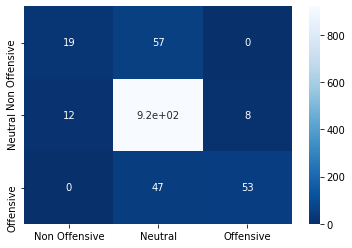

In [53]:
sns.heatmap(cf_df, annot=True, cmap="Blues_r")